In [15]:
import json
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from resnest_train import TestDataset, mixup_data
import torch
from collections import Counter
import random

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(
            brightness=0.7, contrast=0.7, saturation=0.7, hue=0.2),
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.5)
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
    ])
}

train_dataset = datasets.ImageFolder(
    "data/train", transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(
    "data/val", transform=data_transforms['val'])
test_dataset = TestDataset(
    "data/test", transform=data_transforms['test'])

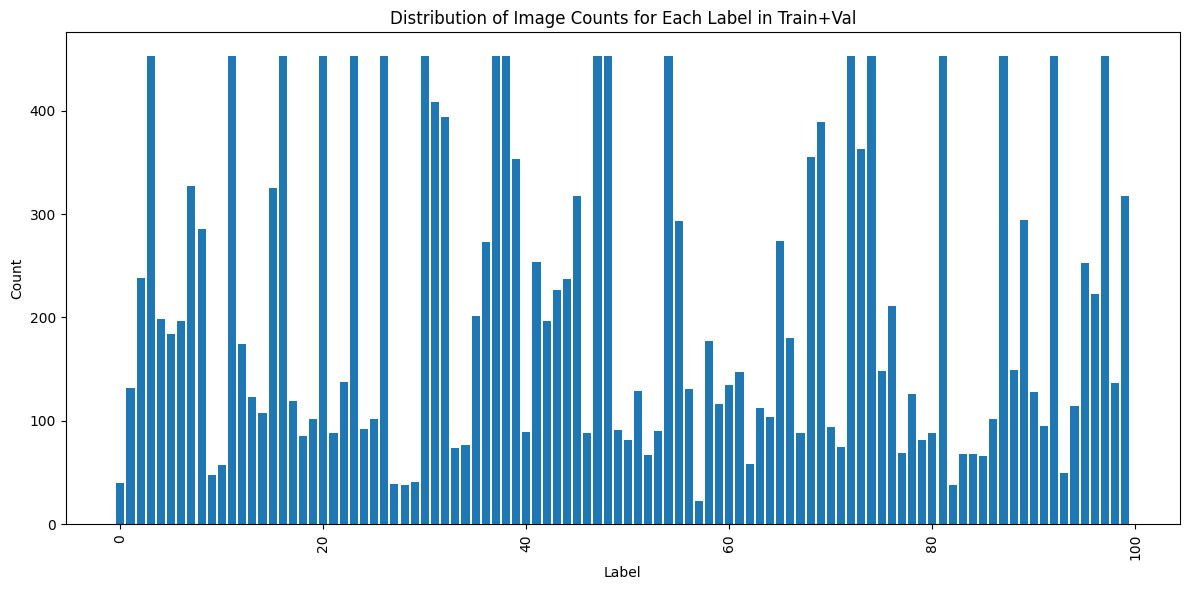

In [8]:
# 結合 train 與 val 的標籤數據
combined_targets = train_dataset.targets + val_dataset.targets

# 計算各類別在 train+val 中的數量
combined_counts = Counter(combined_targets)

# 將 key 轉為整數後排序，方便閱讀（也可依數量排序）
labels = sorted(combined_counts.keys(), key=lambda x: int(x))
counts = [combined_counts[label] for label in labels]

# 畫圖
plt.figure(figsize=(12, 6))
plt.bar(labels, counts)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Image Counts for Each Label in Train+Val')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

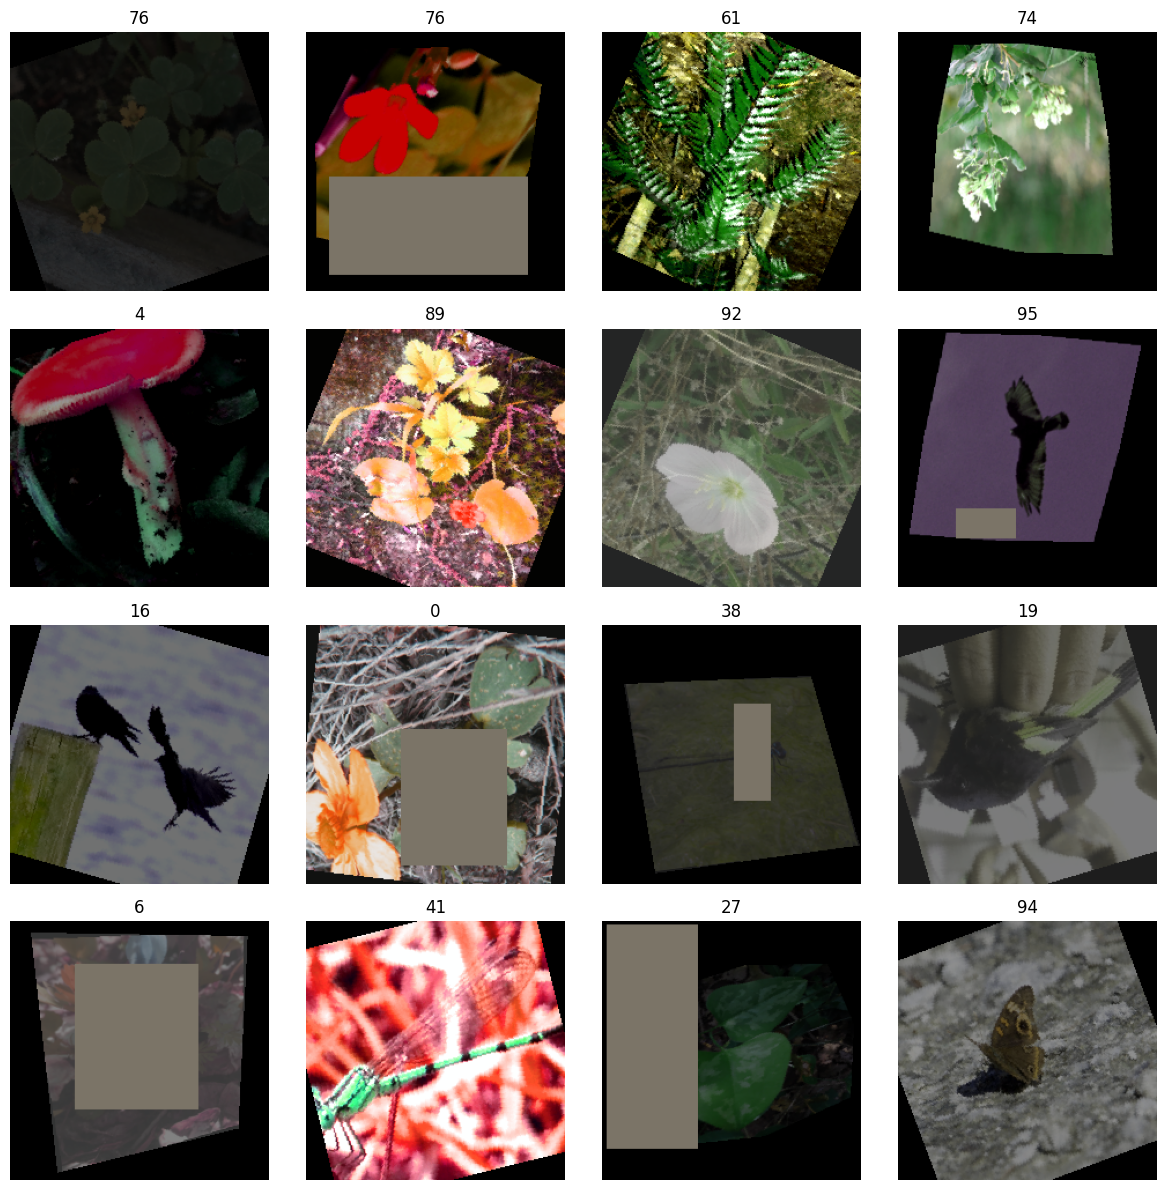

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# 定義反 normalization 的參數
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# 建立 4x4 的子圖網格
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

# 隨機取 16 張圖片的索引
indices = random.sample(range(len(train_dataset)), 16)

for i, idx in enumerate(indices):
    # 每次取一張圖片及其對應的 label
    img, label = train_dataset[idx]
    
    # 將 tensor 轉為 numpy，並從 (C, H, W) 轉置為 (H, W, C)
    img = img.numpy().transpose((1, 2, 0))
    
    # 反 normalization
    img = std * img + mean
    img = np.clip(img, 0, 1)  # 限制在 [0,1] 範圍內
    
    # 顯示圖片及 label (透過 classes 的對應名稱)
    axes[i].imshow(img)
    axes[i].set_title(train_dataset.classes[label])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

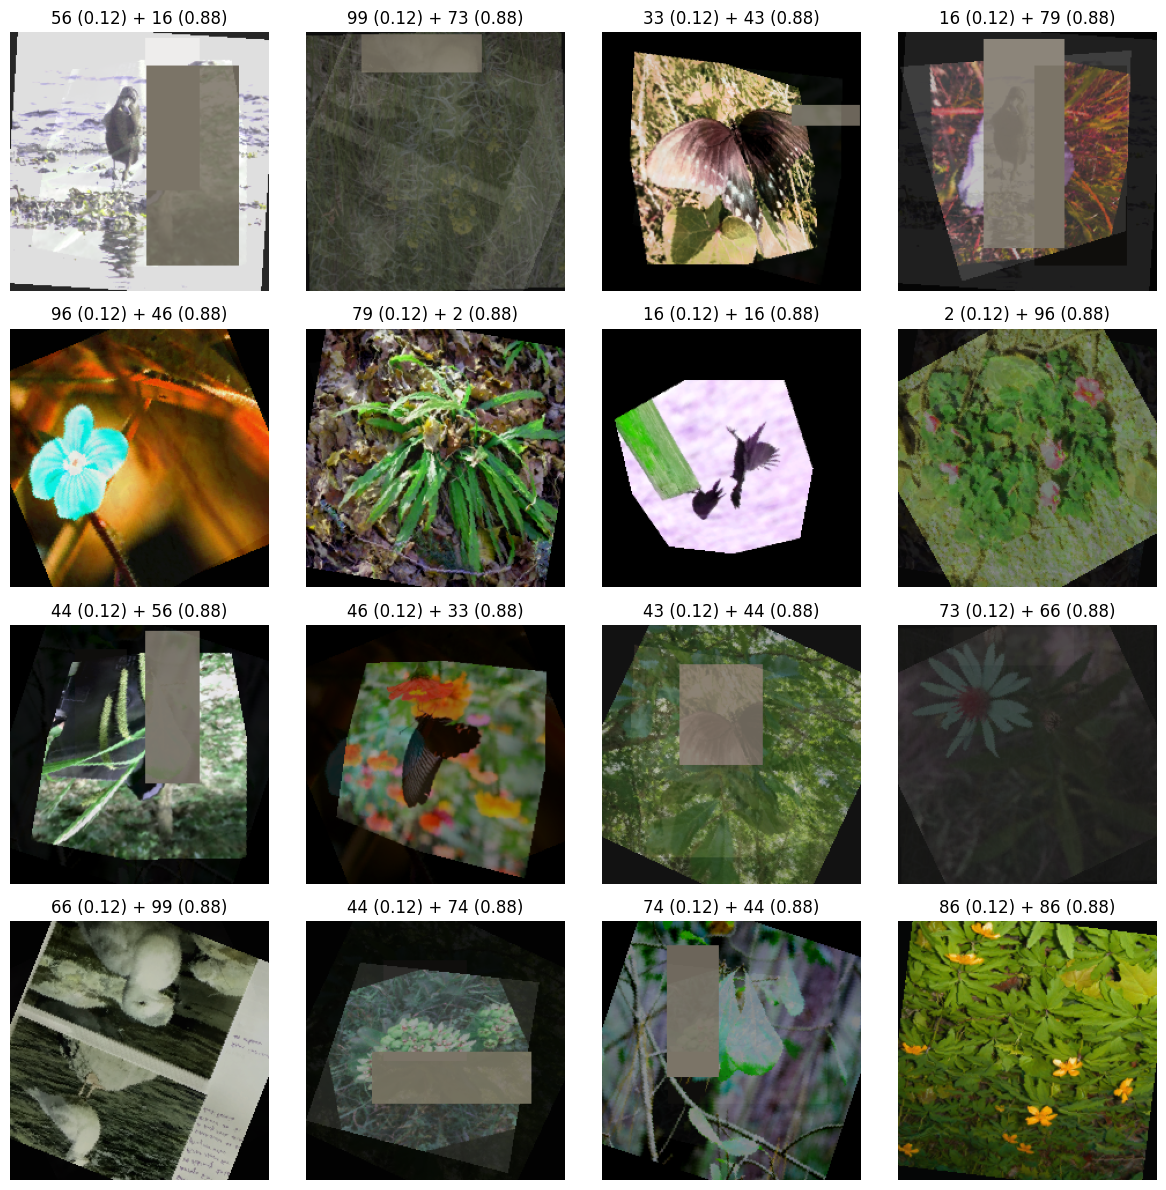

In [16]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random


# 隨機選取 16 張圖片及其 label
indices = random.sample(range(len(train_dataset)), 16)
batch = [train_dataset[i] for i in indices]
x = torch.stack([img for img, label in batch])
y = torch.tensor([label for img, label in batch])

# 判斷使用的 device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
x = x.to(device)
y = y.to(device)

# 進行 mixup augmentation
mixed_x, y_a, y_b, lam = mixup_data(x, y, alpha=0.4, device=device)

# 用於反 normalization 的參數
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# 建立 4x4 的子圖網格以顯示 16 張圖片
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for i in range(16):
    # 將 tensor 轉成 numpy，並由 (C, H, W) 轉為 (H, W, C)
    img = mixed_x[i].cpu().numpy().transpose((1, 2, 0))
    # 反 normalization
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    # 產生 title：顯示 mixup 前兩個 label 以及各自的比例
    title = f"{train_dataset.classes[y_a[i]]} ({lam:.2f}) + {train_dataset.classes[y_b[i]]} ({1-lam:.2f})"
    
    axes[i].imshow(img)
    axes[i].set_title(title)
    axes[i].axis('off')

plt.tight_layout()
plt.show()
